In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt 
from scipy.stats import gaussian_kde
sns.set(style="ticks",)
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})
%matplotlib inline

## Load Data

In [280]:
df = pd.read_csv('../assets/results/results.csv')
seg_time = np.load(r"C:\Users\Jeremy\Documents\UMICH\Research\UnrealRooftopLanding\AirSimCollectData\LidarRoofManualTest\SegmentationInfer\timings.npy")
seg_time[0] = seg_time[1]

df['Segmentation'] = seg_time[:len(df)]
df['t_smoothing'] = df['t_laplacian'] + df['t_bilateral']
df['t_Polylidar3D'] = df['t_mesh'] + df['t_smoothing'] + df['t_fastga_total'] + df['t_polylidar_planepoly'] + df['t_polylidar_filter']
df['t_Total'] = df['t_Polylidar3D'] + df['Segmentation'] + df['t_polylabel'] + df['t_classify_pointcloud']
df.head()


,Unnamed: 0,uid,sub_uid,building,pl_base_iou,pl_seg_gt_iou,pl_seg_infer_iou,computer,t_laplacian,t_bilateral,...,t_fastga_peak,t_polylidar_planepoly,t_polylidar_filter,t_classify_pointcloud,t_polylabel,iou_diff,Segmentation,t_smoothing,t_Polylidar3D,t_Total
0,0,0,0,Building7_Example4,0.939818,0.951617,0.951617,desktop,0.3815,0.4622,...,2.9024,0.9450,1.9429,1.7659,0.0676,-0.011800,23.1339,0.8437,8.0865,33.0539
1,1,0,1,Building7_Example4,0.943499,0.946554,0.946554,desktop,0.3676,0.4346,...,2.7325,0.8883,1.7514,1.7457,0.0533,-0.003055,23.1339,0.8022,7.4097,32.3426
2,2,1,0,Building7_Example4,0.888868,0.909375,0.908213,desktop,0.3583,0.4229,...,2.8980,1.0134,2.6892,1.7517,0.0517,-0.020507,21.0637,0.7812,8.4769,31.3440
3,3,1,1,Building7_Example4,0.893673,0.907671,0.907798,desktop,0.3751,0.4235,...,2.6945,1.0603,2.6788,1.7226,0.0497,-0.013998,20.7461,0.7986,8.2992,30.8176
4,4,2,0,Building7_Example4,0.939941,0.946661,0.946661,desktop,0.3549,0.4287,...,2.6368,0.7670,1.6048,1.4534,0.0397,-0.006720,22.7534,0.7836,6.6369,30.8834


## Specific IOUs
Here are some handpicked IOUs for some visualized examples in the paper

In [281]:
mask = (df['uid'] == 82) & (df['sub_uid'] == 1)
print(len(df))
df[mask]

326


,Unnamed: 0,uid,sub_uid,building,pl_base_iou,pl_seg_gt_iou,pl_seg_infer_iou,computer,t_laplacian,t_bilateral,...,t_fastga_peak,t_polylidar_planepoly,t_polylidar_filter,t_classify_pointcloud,t_polylabel,iou_diff,Segmentation,t_smoothing,t_Polylidar3D,t_Total
151,151,82,1,Building9_Example,0.8642,0.908632,0.913379,desktop,0.3442,0.4652,...,2.9245,1.1077,4.0657,1.7782,0.1208,-0.044432,20.8407,0.8094,10.738,33.4777


In [282]:
uids = df['uid'].to_numpy()
print(len(np.unique(uids)) / 5)
33 * 5 * 2

32.6


330

## Execution Time

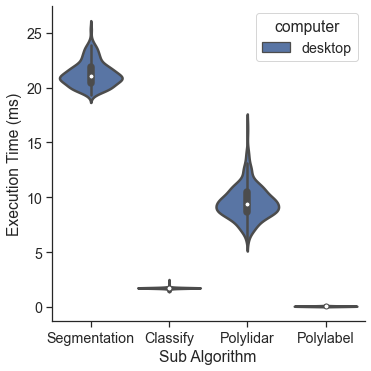

In [283]:
df_simple = df.rename(columns={"t_classify_pointcloud": "Classify", "t_Polylidar3D": "Polylidar", "t_polylabel": "Polylabel" })
df_simple_melt = df_simple.melt(id_vars=["uid", "sub_uid", "computer"],
                                value_vars=['Segmentation','Classify', 'Polylidar', 'Polylabel'],
                                var_name="Sub Algorithm", 
                                value_name="Execution Time (ms)")
g = sns.catplot(data=df_simple_melt, x='Sub Algorithm', hue='computer', y='Execution Time (ms)', kind='violin', legend_out=False)
g.savefig('../assets/imgs/alg_timings.pdf')

In [284]:
df_reduced = df_simple[['Segmentation', 'Classify', 'Polylidar', 'Polylabel', 't_Total']]
df_reduced.describe()

,Segmentation,Classify,Polylidar,Polylabel,t_Total
count,326.000000,326.000000,326.000000,326.000000,326.000000
mean,21.272579,1.736715,9.563334,0.082189,32.654817
std,1.134971,0.082101,1.537649,0.028487,1.828895
min,19.361800,1.435500,6.070600,0.031500,28.759200
25%,20.457025,1.724350,8.646100,0.063825,31.415150
50%,21.055450,1.743100,9.429050,0.078150,32.488000
75%,21.866675,1.761700,10.455325,0.097100,33.587700
max,25.391200,2.461200,16.635800,0.214600,40.064000


## Accuracy

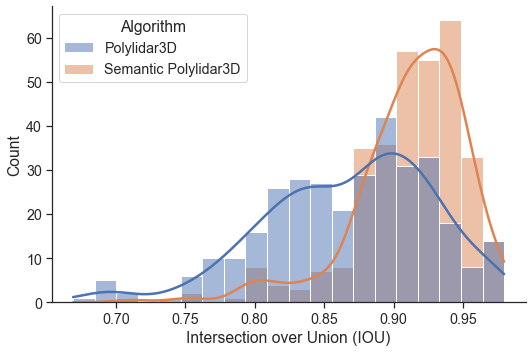

In [235]:
df = df.rename(columns={"pl_base_iou": "Polylidar3D", "pl_seg_infer_iou": "Semantic Polylidar3D"})
df_simple = df.melt(id_vars=["uid", "sub_uid"],
                                value_vars=['Polylidar3D', 'Semantic Polylidar3D'],
                                var_name="Algorithm", 
                                value_name="Intersection over Union (IOU)")
g = sns.displot(df_simple, x="Intersection over Union (IOU)", hue="Algorithm", fill=True, 
                kde=True, facet_kws=dict(legend_out=False), aspect=1.5)
g.savefig('../assets/imgs/compare_algs.pdf')

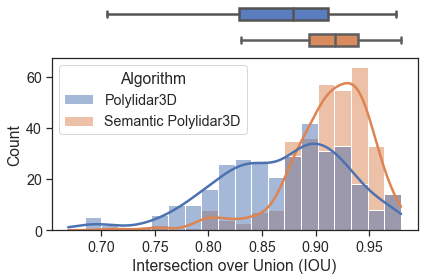

In [236]:
# Inspired from https://www.nature.com/articles/s41561-021-00693-5/figures/3
mask = df_simple['Algorithm'] == 'Polylidar3D'
df_baseline = df_simple[mask]
df_new = df_simple[~mask]
palette = sns.color_palette('muted', 2)
f, (ax_box_baseline, ax_box_new, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (0.075, 0.075, .85)})

g = sns.histplot(df_simple, x="Intersection over Union (IOU)", hue="Algorithm", fill=True, 
                kde=True, ax=ax_hist, legend=True)

sns.boxplot(data=df_baseline, x="Intersection over Union (IOU)", ax=ax_box_baseline, color=palette[0], whis=None, showfliers=False)
sns.boxplot(data=df_new, x="Intersection over Union (IOU)", ax=ax_box_new, color=palette[1], whis=None, showfliers=False)
ax_box_baseline.axis('off')
ax_box_new.axis('off')
f.tight_layout()
f.savefig('../assets/imgs/compare_algs_extra.pdf')

In [237]:
print(df_baseline['Intersection over Union (IOU)'].describe())
print()
print(df_new['Intersection over Union (IOU)'].describe())

count    328.000000
mean       0.868237
std        0.060033
min        0.669240
25%        0.828718
50%        0.878432
75%        0.911779
max        0.975079
Name: Intersection over Union (IOU), dtype: float64

count    328.000000
mean       0.912220
std        0.040453
min        0.711509
25%        0.893679
50%        0.918415
75%        0.939693
max        0.979561
Name: Intersection over Union (IOU), dtype: float64


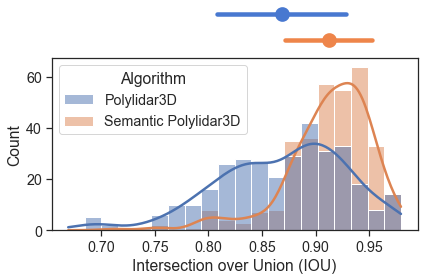

In [238]:
f, (ax_box_baseline, ax_box_new, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (0.075, 0.075, .85)})

g = sns.histplot(df_simple, x="Intersection over Union (IOU)", hue="Algorithm", fill=True, 
                kde=True, ax=ax_hist, legend=True)

sns.pointplot(data=df_baseline, x="Intersection over Union (IOU)", ax=ax_box_baseline, color=palette[0], ci="sd")
sns.pointplot(data=df_new, x="Intersection over Union (IOU)", ax=ax_box_new, color=palette[1], ci="sd")
ax_box_baseline.axis('off')
ax_box_new.axis('off')
f.tight_layout()
f.savefig('../assets/imgs/compare_algs_extra_2.pdf')

In [195]:
## Cross Checking with the internal scipy function
from scipy import stats
t2, p2 = stats.ttest_ind(df_new['Intersection over Union (IOU)'], df_baseline['Intersection over Union (IOU)'], equal_var=True)
print("t = " + str(t2))
print("p = " + str(p2))

t = 10.994697953086854
p = 6.420177887053354e-26
